<a href="https://colab.research.google.com/github/dkim319/Twitter_Sentiment_Analysis/blob/master/1_NLP_Sentiment_Text_Analysis_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - 

## Introduction

This is a Twitter sentiment analysis project to apply the techniques learning in the Deeplearning.ai Tensorflow Developer specialization.  The secondary purpose is to create a template to be used for future NLP classification projects.

This project uses NLTK Twitter samples as a dataset.  There were be three separate notebooks and three separate deep learning models to the same problem.

1.  Simple DNN model
2.  LTSM
3.  Transfer Learning

## 1. Setup

All required libraries are loaded and the Tensorflow version is checked.

In [ ]:
import tensorflow as tf
# !pip install -q tensorflow-datasets
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
import os
from os import getcwd
import matplotlib.pyplot as plt

import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

print(tf.__version__)

2.3.0


The NLTK Twitter dataset is loaded.

In [ ]:
# add folder, tmp2, from our local workspace containing pre-downloaded corpora files to nltk's data path
filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)

nltk.download('stopwords')
nltk.download('twitter_samples')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

This function is created to process the text clean up of tweets


In [ ]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    stemmer = PorterStemmer()
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets

    return tweet

## 2. Prep Data for Deep Learning

The data is split into the training and test datasets (features and labels) and tweets are cleaned up.

In [ ]:
# get the sets of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

train_x_cleaned = []
test_x_cleaned = []

for i, val in enumerate(train_x): 
   train_x_cleaned.append(process_tweet(train_x[i]))
  
for i, val in enumerate(test_x): 
   test_x_cleaned.append(process_tweet(test_x[i]))  

# avoid assumptions about the length of all_positive_tweets
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

Next, the word embedding is created based on the training features and uses post padding and truncation.  Out of vocab token is used to handled words that do not exist in the vocabulary.


In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 50
padding_type = 'post'
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, oov_token=oov_tok)
tokenizer.fit_on_texts(train_x_cleaned)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_x_cleaned)
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type,truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_x)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

The tokeinzer is tested.

In [ ]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences(sentence)
print(sequence)

[[2], [], [428], [726], [6], [1], [1], [652], [], [421], [859], [2], [371], [765], [], [421], [859], [2], [536], [], [2], [536], [], [6], [665], [6], [1], [2], [371], [632], [], [], [859], [413], [371], [726], [536], [421], []]


The embedding vocabulatory is reviewed to see which words are included/excluded.

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(train_x_cleaned[1])

hey james how <OOV> please call our <OOV> <OOV> on <OOV> and we will be able to <OOV> you many thanks ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
 Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!


## 3. Build the Model


The define_model function is created to be able to initialize a word embedding and a model.  It allows for the configuration of the embedding size, model architecture, epochs, and learning rate.  The function also allows for the ability to include a learning rate scheduler and/or a model checkpoint as callbacks.


In [ ]:
def define_model(vocab_size, embedding_dim, max_length, model_number, epoch, learning_rate, lr_cb, cp_cb):

  # set the seed and clear session to ensure consistent results and avoid past models impacting the current model
  tf.keras.backend.clear_session()
  tf.random.set_seed(319)
  np.random.seed(319)

  padding_type = 'post'
  trunc_type='post'
  oov_tok = "<OOV>"
  
  tokenizer = Tokenizer(num_words = vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, oov_token=oov_tok)
  tokenizer.fit_on_texts(train_x_cleaned)
  word_index = tokenizer.word_index
  sequences = tokenizer.texts_to_sequences(train_x_cleaned)
  padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type,truncating=trunc_type)

  testing_sequences = tokenizer.texts_to_sequences(test_x)
  testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

  # initialize the callback list
  callback_list = []

  if model_number==1:
    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  
  if model_number==2:
    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

  if model_number==3:
    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

  optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

  if lr_cb==True:
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
    callback_list.append(lr_schedule)
    optimizer = tf.keras.optimizers.Adam(lr=1e-8)

  if cp_cb==True:
    filepath = str(model_number) + "_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    filedir = os.path.dirname(filepath)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callback_list.append(checkpoint)

  model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
  
  model.summary()

  return tokenizer, model, callback_list

In [ ]:
def chart_acc_loss(model_history):

  history = model_history

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 50
model_number = 3
epoch = 200
learning_rate = 0.001
lr_cb = True
cp_cb = False

tokenizer, model_lr_sched, callback_list = define_model(vocab_size, embedding_dim, max_length, model_number, epoch, learning_rate , lr_cb, cp_cb)

history = model_lr_sched.fit(padded, train_y, 
                  epochs=epoch, 
                  validation_data = (testing_padded, test_y),
                  callbacks=[callback_list])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3204      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 19,209
Trainable params: 19,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
250/250 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.4941 - val_loss: 0.6940 - val_accuracy: 0.4780
Epoch 2/200
250/250 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4941 - val_

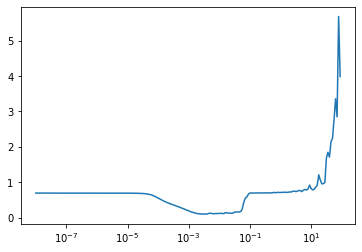

In [ ]:
# review the learning rate performance

plt.semilogx(history.history["lr"], history.history["loss"])

plt.show()

Based on the chart, the learning rate of 0.01(10e-3) appears to be the best option, but when a model is trained using this learning rate.  The accuracy and loss charts show instability, which means that the learning rate is probably too high.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3204      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 19,209
Trainable params: 19,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
237/250 [===========================>..] - ETA: 0s - loss: 0.6568 - accuracy: 0.6262
Epoch 00001: val_accuracy improved from -inf to 0.49050, saving model to 3_weights-improvement-01-0.49.hdf5
250/250 [==============================] - 1s 

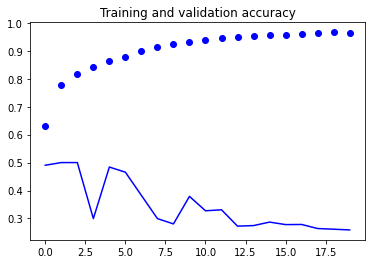

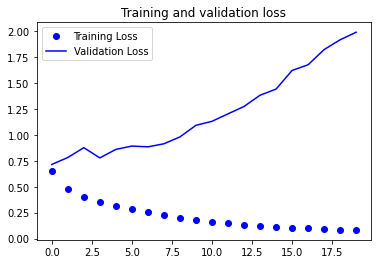

In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 50
model_number = 3
epoch = 20
learning_rate = 0.001
lr_cb = False
cp_cb = True

tokenizer, model_lr_sched, callback_list = define_model(vocab_size, embedding_dim, max_length,model_number, epoch, learning_rate , lr_cb, cp_cb)

history = model_lr_sched.fit(padded, train_y, 
                  epochs=epoch, 
                  validation_data = (testing_padded, test_y),
                  callbacks=[callback_list])

# review the learning rate performance
chart_acc_loss(history)

## Conclusion

The simple DNN model performed poorly against the validation data.  As the model started overfitting, the validation accuracy went down.  This is indicative that the training dataset is not large or sufficient enough to produce a generalized model.  The second notebook will try a different DNN architecture: LTSM.